In [2]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
sns.set()
%load_ext nb_black

<IPython.core.display.Javascript object>

In [33]:
tone_df = pd.read_csv("../data/gkg_nov_2020_sample_topic.csv", usecols=["DATE", "topic", "TONE", "POSITIVE_SCORE", "NEGATIVE_SCORE", "POLARITY"])

<IPython.core.display.Javascript object>

In [36]:
tone_df = tone_df.astype({"DATE":"datetime64", "topic":"category", "TONE":float, "POSITIVE_SCORE":float, "NEGATIVE_SCORE":float, "POLARITY":float})
tone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507819 entries, 0 to 507818
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            507819 non-null  datetime64[ns]
 1   TONE            507819 non-null  float64       
 2   POSITIVE_SCORE  507819 non-null  float64       
 3   NEGATIVE_SCORE  507819 non-null  float64       
 4   POLARITY        507819 non-null  float64       
 5   topic           507819 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(4)
memory usage: 19.9 MB


<IPython.core.display.Javascript object>

In [32]:
pd.merge(tone_df.groupby("topic").mean(), tone_df.groupby("topic")["TONE"].count().rename("COUNT"), left_index=True, right_index=True)

,TONE,POSITIVE_SCORE,NEGATIVE_SCORE,POLARITY,COUNT
topic,,,,,
0,-1.729925,2.941155,4.671080,7.612234,78566
1,-2.012476,2.922137,4.934613,7.856750,66759
2,-0.614997,2.948513,3.563510,6.512023,25804
3,-2.686080,2.463288,5.149368,7.612656,69884
4,-0.798556,2.884224,3.682781,6.567005,66454
5,0.507924,3.207009,2.699086,5.906095,52286
6,0.164546,3.206888,3.042343,6.249231,70666
7,0.113959,3.353735,3.239776,6.593511,77400


<IPython.core.display.Javascript object>

In [40]:
def calculate_daily_average(df):
    return df.groupby(["topic", "DATE"])[["TONE", "POSITIVE_SCORE", "NEGATIVE_SCORE", "POLARITY"]].mean().reset_index(level="topic")

def calculate_first_diff(df):
    df = df.sort_index()
    return df[["TONE", "POSITIVE_SCORE", "NEGATIVE_SCORE", "POLARITY"]].diff().dropna()
     
tone_daily = calculate_daily_average(tone_df)
tone_diff = tone_daily.groupby("topic").apply(calculate_first_diff).reset_index(level="topic")
tone_diff

,topic,TONE,POSITIVE_SCORE,NEGATIVE_SCORE,POLARITY
DATE,,,,,
2020-11-02,1,0.329787,-0.006582,-0.336368,-0.342950
2020-11-03,1,-0.032921,0.086764,0.119685,0.206449
2020-11-04,1,0.366341,-0.030982,-0.397323,-0.428305
2020-11-05,1,-0.252531,-0.042357,0.210174,0.167817
2020-11-06,1,-0.313174,-0.168623,0.144551,-0.024072
...,...,...,...,...,...
2020-11-24,8,-0.140667,-0.055674,0.084993,0.029319
2020-11-25,8,-0.247318,-0.108117,0.139201,0.031084
2020-11-26,8,0.093719,0.027384,-0.066335,-0.038952


<IPython.core.display.Javascript object>

In [42]:
client = bigquery.Client()

query="""
SELECT * from goldenfleece.sentiment.ftse100 order by Date
"""
ftse_df = client.query(query).to_dataframe()
ftse_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2019-09-20,7356.399902,7376.299805,7322.000000,7344.899902,7344.899902,1656288000
1,2019-09-23,7344.899902,7362.299805,7284.799805,7326.100098,7326.100098,489660300
2,2019-09-24,7326.100098,7349.000000,7281.899902,7291.399902,7291.399902,588772200
3,2019-09-25,7291.399902,7292.000000,7213.000000,7290.000000,7290.000000,704553100
4,2019-09-26,7290.000000,7387.100098,7277.200195,7351.100098,7351.100098,704707500


<IPython.core.display.Javascript object>

In [43]:
ftse_df = ftse_df.astype({"Date":"datetime64"}).set_index("Date") 
ftse_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2019-09-20 to 2020-11-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       300 non-null    float64
 1   High       300 non-null    float64
 2   Low        300 non-null    float64
 3   Close      300 non-null    float64
 4   Adj_Close  300 non-null    float64
 5   Volume     300 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 16.4 KB


<IPython.core.display.Javascript object>

In [44]:
adj_close = ftse_df.sort_index()["Adj_Close"]
adj_close_diff = adj_close.diff()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Date'>

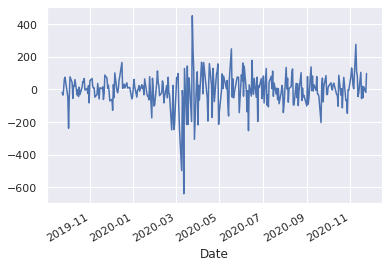

<IPython.core.display.Javascript object>

In [45]:
adj_close_diff.plot()

In [46]:
merged_df = tone_diff.merge(adj_close_diff, left_index=True, right_index=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2020-11-02 to 2020-11-24
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   topic           136 non-null    category
 1   TONE            136 non-null    float64 
 2   POSITIVE_SCORE  136 non-null    float64 
 3   NEGATIVE_SCORE  136 non-null    float64 
 4   POLARITY        136 non-null    float64 
 5   Adj_Close       136 non-null    float64 
dtypes: category(1), float64(5)
memory usage: 6.9 KB


<IPython.core.display.Javascript object>

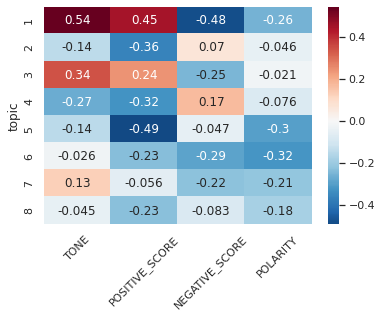

<IPython.core.display.Javascript object>

In [47]:
corr_df = merged_df.groupby("topic").corr(method="pearson")["Adj_Close"].drop(index="Adj_Close", level=1).unstack()

ax = sns.heatmap(corr_df, cmap='RdBu_r', center=0, annot=True)
plt.xticks(rotation=45);

#### Take the first difference of each time series and plot scatterplots

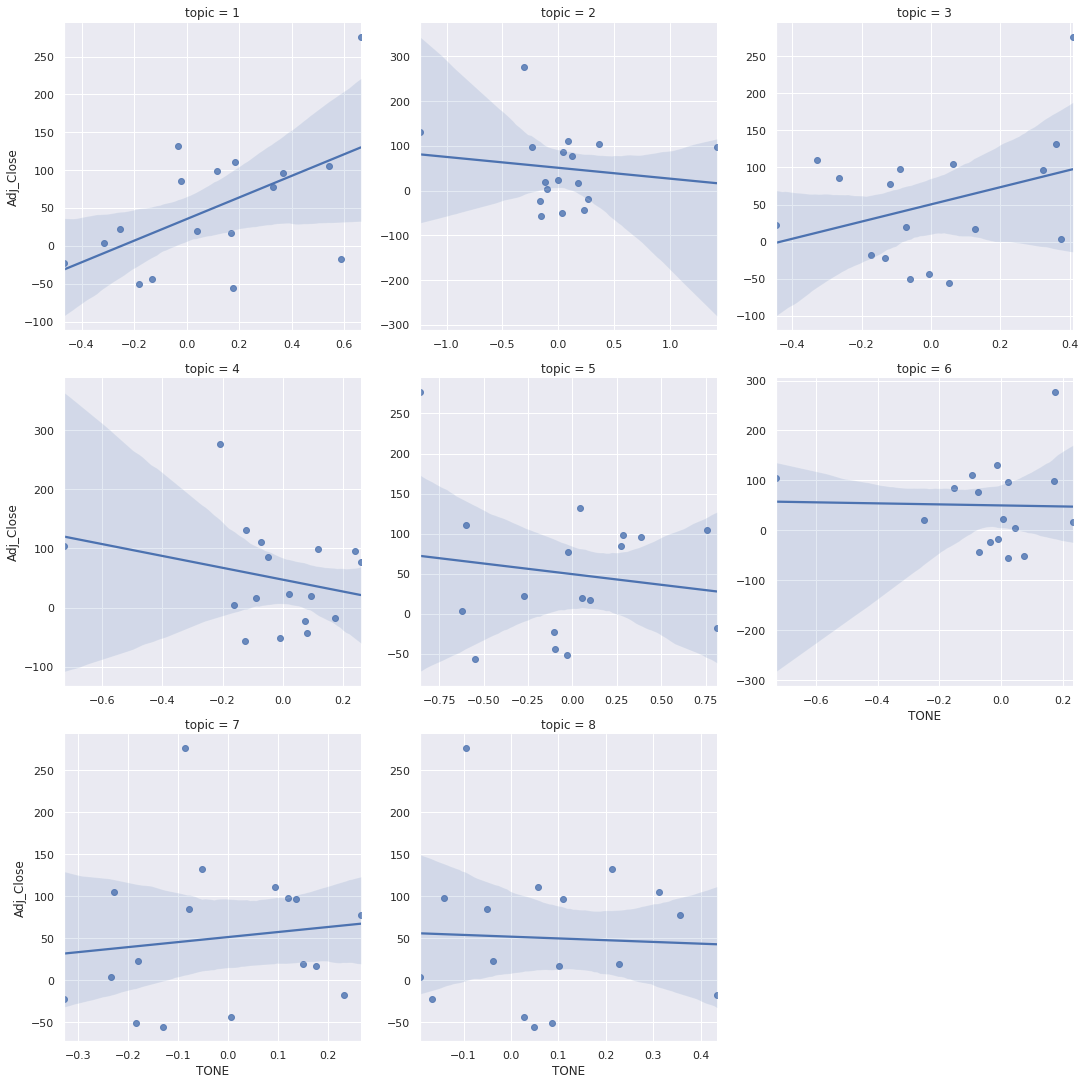

<IPython.core.display.Javascript object>

In [49]:
sns.lmplot(x="TONE", y="Adj_Close", data=merged_df, col="topic", col_wrap=3, sharex=False, sharey=False)

### Investigate cross correlation across topic 1

In [50]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

merged_df_1 = merged_df[merged_df.topic == 1]
tone_cross_correlation = {lag:crosscorr(merged_df_1["TONE"], merged_df_1["Adj_Close"], lag) for lag in range(-10, 10)}

<IPython.core.display.Javascript object>

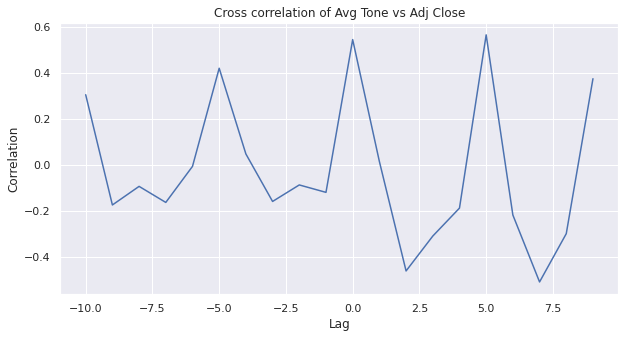

<IPython.core.display.Javascript object>

In [51]:
ax = pd.Series(tone_cross_correlation).plot(figsize=(10,5))
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation")
ax.set_title("Cross correlation of Avg Tone vs Adj Close");